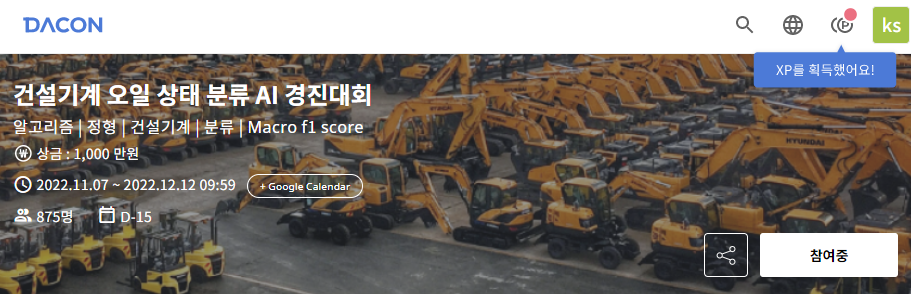

In [1587]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore') 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [1588]:
file_version = 25
CFG = {
    'EPOCHS': 30,
    'LEARNING_RATE':1e-2,    # 0.01
    'BATCH_SIZE':256,
    'SEED':43,
    '보간값적용':"최빈값",
    'log_transform_turn': 1,  # 로그 트랜스폼을 몇번 돌릴 것인가?
    'skew_cut':0.01,           # 왜도 얼마 이상을 로그값으로 정규화할 것인가?(100이면 안하겠다는 것)
    'vif_cut': 10,           # 다중공선성 vif 얼마 이상을 제거할 것인가?
    'corr_cut': 0.005,     # 일정 상관관계 이하 칼럼은 드랍
    'outlier_corr_cut': 100,    # 이값 이상의 상관관계를 갖는 칼럼에 대해서만 아웃라이어 제거(100이면 미적용)
    'T_Thresh': 0.2,     # Teacher model train Threshhold 최초 0.35
    'S_Thresh': 0.2,     # Student model train Threshold 최초 0.35
    'reduct' : 'mean',      # sum, mean
    'drop_rate': 0.2,
    
}

In [1589]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

# 1. EDA

- 결측치 처리
- 왜도 정규화 처리
- 스케일링
- 다중공선성 검토

In [1590]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [1591]:
train["Y_LABEL"].value_counts()

0    12892
1     1203
Name: Y_LABEL, dtype: int64

In [1642]:
# train.info()

In [1643]:
# test.info()

## (1) 결측치

<AxesSubplot:>

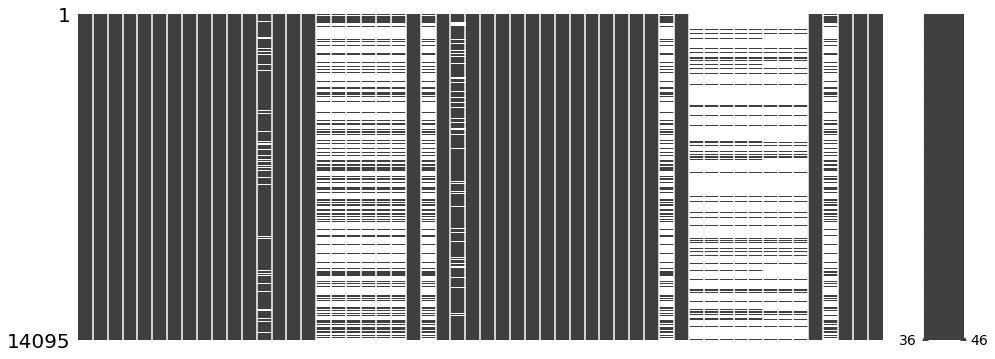

In [1594]:
import missingno as msno
msno.matrix(train, figsize=(16,6))

In [1595]:
train.describe(include="all")

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
count,14095,14095,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,14095.000000,...,2316.000000,2316.000000,2118.000000,2118.000000,2118.000000,14095.000000,3724.000000,14095.000000,14095.000000,14095.000000
unique,14095,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,TRAIN_00000,COMPONENT3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,7050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,3146.082937,2013.652501,7.600568,387.416885,0.025825,12.707698,64.026179,0.692799,...,29.870898,56.063472,239.938149,5488.693107,19415.597262,0.050656,13.576230,109.355815,588.646825,0.085349
std,NaN,NaN,4216.089809,3.964758,11.681628,550.016073,0.171926,86.968000,102.876871,2.905491,...,97.459625,184.332678,685.053457,15474.146283,40145.311444,0.475438,1.073718,49.612379,531.743393,0.279411
min,NaN,NaN,1000.000000,2007.000000,0.000000,200.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,15.000000,154.000000,0.000000,5.200000,2.900000,0.000000,0.000000
25%,NaN,NaN,1655.000000,2010.000000,3.000000,200.000000,0.000000,1.000000,3.000000,0.000000,...,3.000000,5.000000,22.000000,636.750000,5409.250000,0.000000,12.900000,71.800000,37.000000,0.000000
50%,NaN,NaN,2227.000000,2014.000000,5.000000,200.000000,0.000000,2.000000,11.000000,0.000000,...,7.000000,13.000000,57.000000,1753.000000,12691.500000,0.000000,13.500000,111.300000,520.000000,0.000000
75%,NaN,NaN,3797.000000,2017.000000,8.000000,410.000000,0.000000,4.000000,110.000000,0.000000,...,23.000000,39.250000,189.000000,5517.750000,24535.750000,0.000000,14.200000,137.200000,1119.000000,0.000000


In [1596]:
def 보간값(col):
    평균 = train[col].mean()
    중위수 = train[col].median()
    최빈값 = train[col].mode().values[0]
    return {"평균": 평균, "중위수": 중위수, "최빈값":최빈값}

In [1597]:
null_columns = []
for col in train.columns.tolist():
    if train[col].isna().any():
        null_columns.append(col)
        평균 = 보간값(col)["평균"]
        중위수 = 보간값(col)["중위수"]
        최빈값 = 보간값(col)["최빈값"]
        print(f"칼럼명: {col}, 평균: {평균:.2f}, 중위수: {중위수}, 최빈값: {최빈값}")
    else:
        pass   

칼럼명: CD, 평균: 0.02, 중위수: 0.0, 최빈값: 0.0
칼럼명: FH2O, 평균: 15.24, 중위수: 13.0, 최빈값: 14.0
칼럼명: FNOX, 평균: 7.14, 중위수: 7.0, 최빈값: 6.0
칼럼명: FOPTIMETHGLY, 평균: 0.53, 중위수: 0.0, 최빈값: 0.0
칼럼명: FOXID, 평균: 12.50, 중위수: 12.0, 최빈값: 11.0
칼럼명: FSO4, 평균: 20.28, 중위수: 20.0, 최빈값: 20.0
칼럼명: FTBN, 평균: 8.78, 중위수: 8.7, 최빈값: 8.2
칼럼명: FUEL, 평균: 0.19, 중위수: 0.0, 최빈값: 0.0
칼럼명: K, 평균: 3.61, 중위수: 2.0, 최빈값: 0.0
칼럼명: SOOTPERCENTAGE, 평균: 0.61, 중위수: 0.4, 최빈값: 0.2
칼럼명: U100, 평균: 0.17, 중위수: 0.0, 최빈값: 0.0
칼럼명: U75, 평균: 0.42, 중위수: 0.0, 최빈값: 0.0
칼럼명: U50, 평균: 6.19, 중위수: 1.0, 최빈값: 0.0
칼럼명: U25, 평균: 29.87, 중위수: 7.0, 최빈값: 1.0
칼럼명: U20, 평균: 56.06, 중위수: 13.0, 최빈값: 4.0
칼럼명: U14, 평균: 239.94, 중위수: 57.0, 최빈값: 14.0
칼럼명: U6, 평균: 5488.69, 중위수: 1753.0, 최빈값: 300.0
칼럼명: U4, 평균: 19415.60, 중위수: 12691.5, 최빈값: 6789.0
칼럼명: V100, 평균: 13.58, 중위수: 13.5, 최빈값: 13.3


In [1598]:
train[null_columns].describe(include="all")

,CD,FH2O,FNOX,FOPTIMETHGLY,FOXID,FSO4,FTBN,FUEL,K,SOOTPERCENTAGE,U100,U75,U50,U25,U20,U14,U6,U4,V100
count,12701.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,11796.000000,3890.000000,2316.000000,2316.000000,2316.000000,2316.000000,2316.000000,2118.000000,2118.000000,2118.000000,3724.000000
mean,0.015589,15.242159,7.138303,0.532905,12.495373,20.284319,8.783239,0.185347,3.611224,0.609254,0.173575,0.417098,6.185233,29.870898,56.063472,239.938149,5488.693107,19415.597262,13.576230
std,0.209407,17.591679,1.860775,0.621937,3.439535,3.234296,1.339355,0.899253,15.630404,0.652382,0.878892,1.626333,36.639482,97.459625,184.332678,685.053457,15474.146283,40145.311444,1.073718
min,0.000000,6.000000,3.000000,0.000000,4.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,154.000000,5.200000
25%,0.000000,11.000000,6.000000,0.000000,10.000000,18.000000,8.100000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,3.000000,5.000000,22.000000,636.750000,5409.250000,12.900000
50%,0.000000,13.000000,7.000000,0.000000,12.000000,20.000000,8.700000,0.000000,2.000000,0.400000,0.000000,0.000000,1.000000,7.000000,13.000000,57.000000,1753.000000,12691.500000,13.500000
75%,0.000000,15.000000,8.000000,1.000000,14.750000,22.000000,9.600000,0.000000,3.000000,0.800000,0.000000,0.000000,3.000000,23.000000,39.250000,189.000000,5517.750000,24535.750000,14.200000
max,18.000000,320.000000,38.000000,13.000000,68.000000,68.000000,27.700000,12.000000,705.000000,6.500000,18.000000,33.000000,939.000000,1651.000000,2932.000000,11296.000000,412627.000000,844421.000000,29.900000


In [1599]:
print(null_columns)

['CD', 'FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4', 'FTBN', 'FUEL', 'K', 'SOOTPERCENTAGE', 'U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4', 'V100']


In [1644]:
# nan 보간 : 평균 or 중위수 or 최빈값
보간값적용 = "최빈값"
def 보간함수(val):
    for col in null_columns:
        a = 보간값(col)[val] # 최빈값
        print(a)
        train[col] = train[col].fillna(a)
# 보간함수(보간값적용)

<AxesSubplot:>

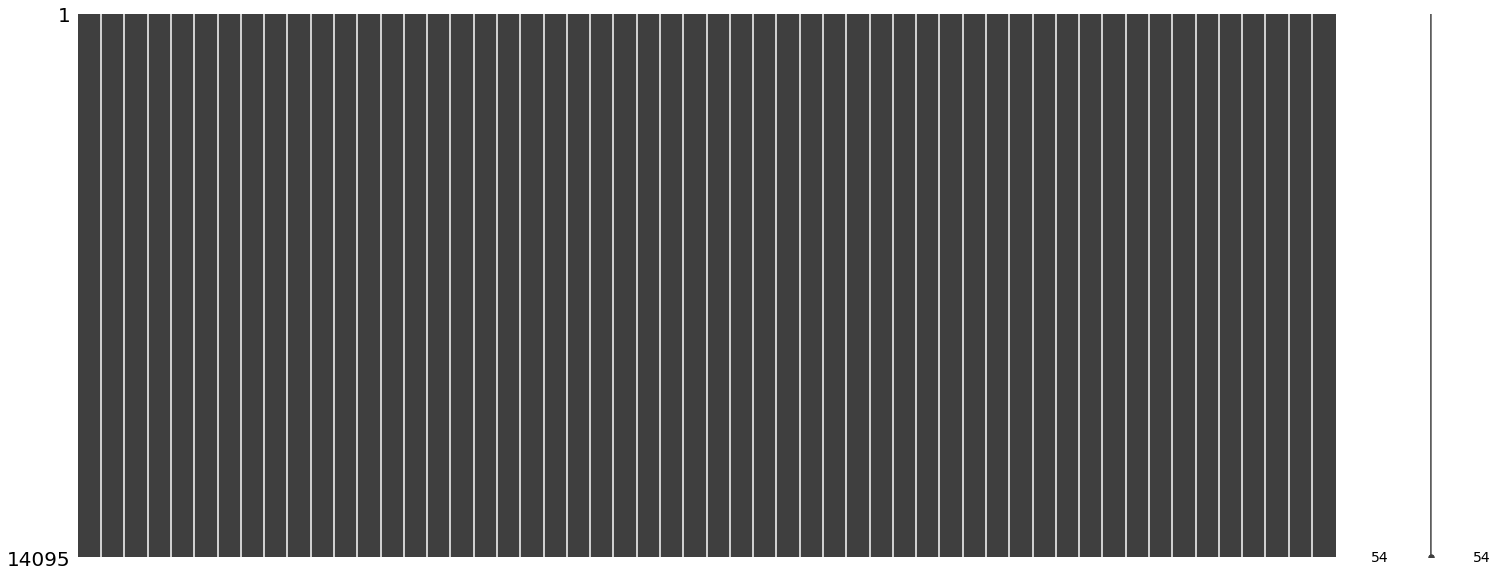

In [1601]:
msno.matrix(train)

## (2) 왜도 검토 - `Log Transform`

In [1602]:
# not_number_features = ['ID','COMPONENT_ARBITRARY', 'YEAR', "Y_LABEL"]
not_number_features = ['ID','COMPONENT_ARBITRARY', 'YEAR', "Y_LABEL"]

numerical_cols = list(set(train.columns.tolist())-set(not_number_features))
print(numerical_cols)
print(len(numerical_cols))

['SB', 'FTBN', 'CU', 'ANONYMOUS_2', 'LI', 'CD', 'U75', 'CR', 'FH2O', 'SOOTPERCENTAGE', 'NA', 'CA', 'FOPTIMETHGLY', 'U20', 'V40', 'FOXID', 'AG', 'NI', 'S', 'SAMPLE_TRANSFER_DAY', 'K', 'SN', 'BE', 'FE', 'TI', 'ZN', 'U25', 'MO', 'AL', 'FSO4', 'MN', 'H2O', 'PB', 'U14', 'PQINDEX', 'ANONYMOUS_1', 'U50', 'U6', 'B', 'BA', 'SI', 'U100', 'V', 'MG', 'V100', 'U4', 'FNOX', 'P', 'CO', 'FUEL']
50


In [1603]:
#박스 플롯
def box_plot(df):
    세로열 = 3
    가로열 = int(len(numerical_cols)/세로열+1)

    fig, axes = plt.subplots(가로열, 3, figsize=(18, 30))
    a = 0
    for i, col in enumerate(numerical_cols):
            b=i%3
            sns.boxplot(ax=axes[a, b], data=df, x='Y_LABEL', y=col)
            if b == 2:
                a += 1

In [1604]:
# box_plot(train)

In [1605]:
def skew_chart(df):
    세로열 = 3
    가로열 = int(len(df.columns)/세로열+1)

    fig, axes = plt.subplots(가로열, 3, figsize=(20, 30))
    a = 0
    for i, col in enumerate(skew_feats):
        b=i%3
        sns.distplot(df[col], bins=100, ax=axes[a, b])
        plt.gca().set_title(col)
        plt.subplots_adjust(hspace = 0.8)
        if b == 2:
            a += 1

In [1606]:
# skew_chart(train)

In [1607]:
skewness = train[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
skewness

CD                     55.899106
CR                     54.368366
CO                     49.810892
H2O                    48.656666
NA                     43.060333
U50                    41.706142
BE                     40.923712
SN                     39.878475
PB                     39.602904
MN                     38.915313
U6                     36.709851
BA                     34.836012
TI                     34.500761
K                      30.920025
ANONYMOUS_1            30.451948
LI                     28.675390
U4                     28.420830
U100                   26.087449
SB                     25.174375
FH2O                   23.692474
U75                    22.869479
AL                     22.037843
U25                    22.010478
U20                    21.665249
V                      20.985827
CU                     20.741422
NI                     20.387033
FE                     20.119119
U14                    19.628971
FUEL                   14.826516
SI        

In [1608]:
for i in tqdm(range(CFG["log_transform_turn"])):
    skewness = train[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
    skew_feats = skewness[skewness > CFG["skew_cut"]].index
    
    log_train = train[skew_feats].copy()
    log_train[skew_feats] = np.log1p(log_train[skew_feats])
        
    for col in skew_feats:
        train[col] = log_train[col]
    
    skewness = train[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
    print("-"*40)
    print(skew_feats)
    print(skewness)
    
    for col in skew_feats:
        if col in test.columns:
            test[col] = np.log1p(test[col])
        else:
            pass

  0%|          | 0/1 [00:00<?, ?it/s]

----------------------------------------
Index(['CD', 'CR', 'CO', 'H2O', 'NA', 'U50', 'BE', 'SN', 'PB', 'MN', 'U6',
       'BA', 'TI', 'K', 'ANONYMOUS_1', 'LI', 'U4', 'U100', 'SB', 'FH2O', 'U75',
       'AL', 'U25', 'U20', 'V', 'CU', 'NI', 'FE', 'U14', 'FUEL', 'SI', 'V40',
       'SAMPLE_TRANSFER_DAY', 'PQINDEX', 'ANONYMOUS_2', 'AG', 'MG',
       'SOOTPERCENTAGE', 'FOPTIMETHGLY', 'FSO4', 'FOXID', 'FNOX', 'MO', 'B',
       'V100', 'FTBN', 'P', 'S', 'CA', 'ZN'],
      dtype='object')
BE                     23.412466
H2O                    18.578013
CD                     11.885586
U100                   11.430049
CO                      9.008246
FUEL                    8.774924
V                       8.296009
U75                     8.282828
FH2O                    7.129355
AG                      6.600190
LI                      5.496954
U50                     5.171332
TI                      4.836962
U20                     3.716015
U14                     3.641633
U25               

In [1609]:
# skew_chart(train)

## (3) Scaling

In [1610]:
categorical_features = ['ID','COMPONENT_ARBITRARY', 'YEAR', "Y_LABEL"]

In [1611]:
train.head(2)

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,7.304516,2011,2.079442,5.303305,0.0,1.386294,4.543295,0.0,...,0.693147,1.609438,2.70805,5.707110,8.823206,0.0,2.66026,5.043425,4.330733,0
1,TRAIN_00001,COMPONENT2,7.208600,2021,3.951244,5.929589,0.0,1.098612,2.995732,0.0,...,1.098612,1.609438,1.94591,5.379897,7.282761,0.0,2.66026,3.806662,6.481577,0


In [1612]:
def get_values(value):
    return value.values.reshape(-1, 1)

for col in train.columns:
    if col not in categorical_features:   # 범주형 칼럼이 아니라면 표준화
        scaler = StandardScaler()
        train[col] = scaler.fit_transform(get_values(train[col]))
        if col in test.columns:
            test[col] = scaler.transform(get_values(test[col]))
            
train.head(2)

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,-0.912752,2011,0.32087,-0.623928,-0.153746,0.144147,0.961928,-0.49312,...,-0.331879,-0.279405,-0.287731,-0.315740,-0.152256,-0.154507,-0.11184,1.007861,-0.614230,0
1,TRAIN_00001,COMPONENT2,-1.076829,2021,3.16213,0.405018,-0.153746,-0.117480,0.116099,-0.49312,...,0.174974,-0.279405,-1.253186,-0.693414,-3.502802,-0.154507,-0.11184,-1.939387,0.606862,0


## (4) 다중공선성 검토

In [1613]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [1614]:
train1 = train.copy()

In [1615]:
train1 = train1[numerical_cols].astype(float)
train1.shape

(14095, 50)

In [1616]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train1.values, i) for i in range(train1.shape[1])]
vif["features"] = train1.columns 
vif

,VIF Factor,features
0,1.185587,SB
1,1.342818,FTBN
2,1.886103,CU
3,1.074600,ANONYMOUS_2
4,1.090151,LI
5,1.035318,CD
6,4.175163,U75
7,3.228070,CR
8,1.602631,FH2O
9,3.480556,SOOTPERCENTAGE


In [1617]:
vif_10이상 = vif[vif["VIF Factor"]> CFG["vif_cut"]]
vif_drop = vif_10이상["features"].tolist()
vif_drop

['U20', 'U25', 'U14', 'U6']

In [1618]:
train1 = train1.drop(vif_drop,axis=1)

In [1619]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train1.values, i) for i in range(train1.shape[1])]
vif["features"] = train1.columns 
vif

,VIF Factor,features
0,1.183225,SB
1,1.342465,FTBN
2,1.871325,CU
3,1.073552,ANONYMOUS_2
4,1.087841,LI
5,1.034448,CD
6,4.133322,U75
7,3.174563,CR
8,1.599506,FH2O
9,3.468504,SOOTPERCENTAGE


## (5) 상관관계 검토

In [1620]:
train.head()

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,-0.912752,2011,0.320870,-0.623928,-0.153746,0.144147,0.961928,-0.493120,...,-0.331879,-0.279405,-0.287731,-0.315740,-0.152256,-0.154507,-0.11184,1.007861,-0.614230,0
1,TRAIN_00001,COMPONENT2,-1.076829,2021,3.162130,0.405018,-0.153746,-0.117480,0.116099,-0.493120,...,0.174974,-0.279405,-1.253186,-0.693414,-3.502802,-0.154507,-0.11184,-1.939387,0.606862,0
2,TRAIN_00002,COMPONENT2,-0.082488,2015,-1.167958,-0.623928,-0.153746,3.166397,-1.142392,0.744462,...,-1.198350,-0.589690,0.954753,3.864920,3.763094,-0.154507,-0.11184,-0.766976,0.346769,1
3,TRAIN_00003,COMPONENT3,1.830033,2010,-1.167958,-0.623928,-0.153746,0.881631,-0.763548,-0.493120,...,-0.331879,-0.279405,-0.287731,-0.315740,-0.152256,-0.154507,-0.11184,0.666255,-1.892349,0
4,TRAIN_00004,COMPONENT3,0.760631,2015,-0.392562,-0.623928,-0.153746,-0.486222,1.245755,-0.493120,...,-0.331879,-0.279405,-0.287731,-0.315740,-0.152256,-0.154507,-0.11184,0.662704,-0.313858,0


In [1621]:
train.drop(vif_drop ,axis=1, inplace=True)

In [1622]:
train.head()

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,TI,U100,U75,U50,U4,V,V100,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,-0.912752,2011,0.320870,-0.623928,-0.153746,0.144147,0.961928,-0.493120,...,3.210181,-0.109803,-0.153211,-0.257492,-0.152256,-0.154507,-0.11184,1.007861,-0.614230,0
1,TRAIN_00001,COMPONENT2,-1.076829,2021,3.162130,0.405018,-0.153746,-0.117480,0.116099,-0.493120,...,-0.264003,-0.109803,-0.153211,1.033074,-3.502802,-0.154507,-0.11184,-1.939387,0.606862,0
2,TRAIN_00002,COMPONENT2,-0.082488,2015,-1.167958,-0.623928,-0.153746,3.166397,-1.142392,0.744462,...,-0.264003,-0.109803,-0.153211,-0.257492,3.763094,-0.154507,-0.11184,-0.766976,0.346769,1
3,TRAIN_00003,COMPONENT3,1.830033,2010,-1.167958,-0.623928,-0.153746,0.881631,-0.763548,-0.493120,...,-0.264003,-0.109803,-0.153211,-0.257492,-0.152256,-0.154507,-0.11184,0.666255,-1.892349,0
4,TRAIN_00004,COMPONENT3,0.760631,2015,-0.392562,-0.623928,-0.153746,-0.486222,1.245755,-0.493120,...,-0.264003,-0.109803,-0.153211,-0.257492,-0.152256,-0.154507,-0.11184,0.662704,-0.313858,0


<AxesSubplot:>

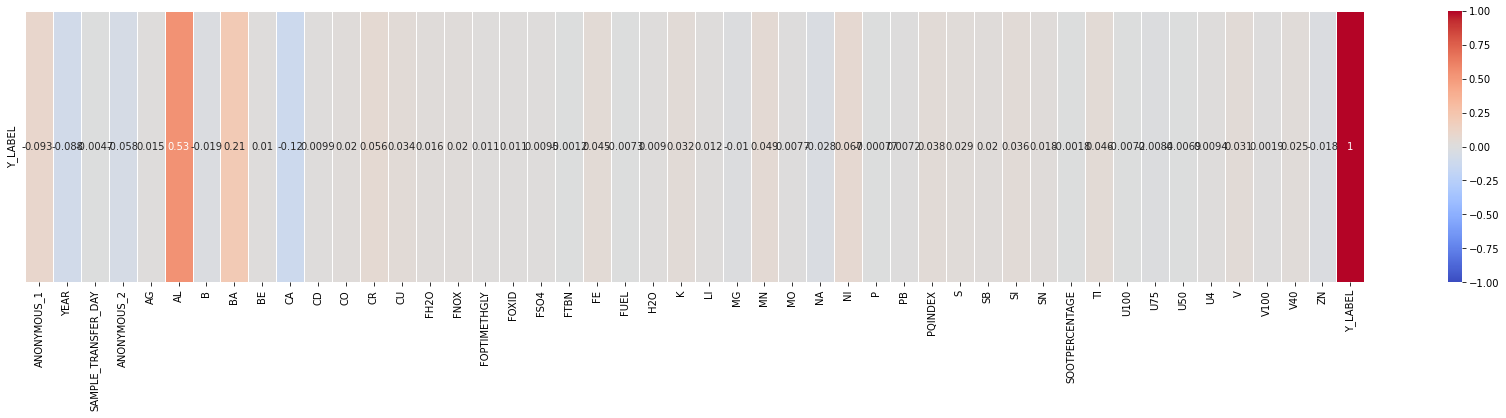

In [1623]:
fig = plt.figure(figsize=(30, 5))
sns.heatmap(train.loc[:,:].corr()[["Y_LABEL"]].T, annot=True, linewidth=1, cmap="coolwarm", vmin=-1, vmax=1)

In [1624]:
df_corr = pd.DataFrame(train.corr()["Y_LABEL"].sort_values(ascending=False))
df_corr

,Y_LABEL
Y_LABEL,1.000000
AL,0.531680
BA,0.205176
ANONYMOUS_1,0.092820
NI,0.067153
CR,0.056019
MN,0.048509
TI,0.046066
FE,0.045108
PQINDEX,0.037558


In [1625]:
# 상관관계가 낮아서 제낄 칼럼들
cutline = CFG["corr_cut"]
df_corr1 = df_corr[(df_corr["Y_LABEL"] < cutline) & (df_corr["Y_LABEL"] > (cutline*-1))]
print(f"상관관계가 낮아서 드랍할 칼럼 개수 : {len(df_corr1.index)}")
df_corr1.sort_values

상관관계가 낮아서 드랍할 칼럼 개수 : 5


<bound method DataFrame.sort_values of                       Y_LABEL
V100                 0.001948
P                   -0.000769
FTBN                -0.001173
SOOTPERCENTAGE      -0.001773
SAMPLE_TRANSFER_DAY -0.004679>

## (6) 수치형 데이터 이상치 처리

In [1626]:
not_number_features = ['ID','COMPONENT_ARBITRARY', 'YEAR', "Y_LABEL"]
train.drop(columns = "ID", axis = 1, inplace = True)
test.drop(columns = "ID", axis = 1, inplace = True)

In [1627]:
#이상치 인덱스 확인 함수
def get_outlier(df=None, col=None, weight=1.5):
    target = df[col]
    quantile_25 = np.quantile(target, 0.25)
    quantile_75 = np.quantile(target, 0.75)
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    outlier_index = target[(target < lowest_val) | (target > highest_val)].index
    return outlier_index

In [1628]:
get_outlier(train, "CO")

Int64Index([   23,    35,    95,   106,   205,   224,   225,   250,   265,
              343,
            ...
            13739, 13756, 13794, 13798, 13812, 13999, 14021, 14049, 14059,
            14086],
           dtype='int64', length=297)

In [1629]:
이상치칼럼 = []
huddle = CFG["outlier_corr_cut"]  # 허들이상의 상관관계를 가진 칼럼에 대해서만 이상치 드랍
print(huddle)

for target1 in train.columns:
    if target1 not in not_number_features and ((df_corr.loc[[target1]].values[0][0] >= huddle) or (df_corr.loc[[target1]].values[0][0] <= (huddle*-1))):
        이상치칼럼.append(target1)
        
        outlier_index = get_outlier(train, target1)
        print(f"검토대상: {target1}, 상관관계: {df_corr.loc[[target1]].values[0][0]:.2f}, 드랍갯수: {len(outlier_index)}")
        
        train.drop(index=outlier_index, inplace=True)

    else:
        pass
    
# print(f"이상치칼럼: {target1}, "드랍갯수": {len(outlier_index)})

100


In [1630]:
if target1 in 이상치칼럼 :
    print(target1)
    outlier_index2 = get_outlier(test, target1)
    print(f"드랍대상 아웃라이어 인덱스 갯수 : {len(outlier_index2)}")

    test.drop(index=outlier_index, inplace=True)
else:
    pass

In [1631]:
train.head(2)

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,...,TI,U100,U75,U50,U4,V,V100,V40,ZN,Y_LABEL
0,COMPONENT3,-0.912752,2011,0.32087,-0.623928,-0.153746,0.144147,0.961928,-0.49312,-0.054428,...,3.210181,-0.109803,-0.153211,-0.257492,-0.152256,-0.154507,-0.11184,1.007861,-0.614230,0
1,COMPONENT2,-1.076829,2021,3.16213,0.405018,-0.153746,-0.117480,0.116099,-0.49312,-0.054428,...,-0.264003,-0.109803,-0.153211,1.033074,-3.502802,-0.154507,-0.11184,-1.939387,0.606862,0


## (7) 원핫인코딩

In [1632]:
def onehot_encode(df, target_list):
    ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(drop='first', sparse=False), [0, 2])], remainder='passthrough')
    df = ct.fit_transform(df)
    df = pd.DataFrame(df)
    new_name = ct.get_feature_names()
    df.columns = new_name
    return df

In [1633]:
train = onehot_encode(train, [0,2])
train.columns

Index(['encoder__x0_COMPONENT2', 'encoder__x0_COMPONENT3',
       'encoder__x0_COMPONENT4', 'encoder__x1_2008', 'encoder__x1_2009',
       'encoder__x1_2010', 'encoder__x1_2011', 'encoder__x1_2012',
       'encoder__x1_2013', 'encoder__x1_2014', 'encoder__x1_2015',
       'encoder__x1_2016', 'encoder__x1_2017', 'encoder__x1_2018',
       'encoder__x1_2019', 'encoder__x1_2020', 'encoder__x1_2021',
       'encoder__x1_2022', 'ANONYMOUS_1', 'SAMPLE_TRANSFER_DAY', 'ANONYMOUS_2',
       'AG', 'AL', 'B', 'BA', 'BE', 'CA', 'CD', 'CO', 'CR', 'CU', 'FH2O',
       'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4', 'FTBN', 'FE', 'FUEL', 'H2O',
       'K', 'LI', 'MG', 'MN', 'MO', 'NA', 'NI', 'P', 'PB', 'PQINDEX', 'S',
       'SB', 'SI', 'SN', 'SOOTPERCENTAGE', 'TI', 'U100', 'U75', 'U50', 'U4',
       'V', 'V100', 'V40', 'ZN', 'Y_LABEL'],
      dtype='object')

In [1634]:
test = onehot_encode(test, [0,2])
test.columns

Index(['encoder__x0_COMPONENT2', 'encoder__x0_COMPONENT3',
       'encoder__x0_COMPONENT4', 'encoder__x1_2008', 'encoder__x1_2009',
       'encoder__x1_2010', 'encoder__x1_2011', 'encoder__x1_2012',
       'encoder__x1_2013', 'encoder__x1_2014', 'encoder__x1_2015',
       'encoder__x1_2016', 'encoder__x1_2017', 'encoder__x1_2018',
       'encoder__x1_2019', 'encoder__x1_2020', 'encoder__x1_2021',
       'encoder__x1_2022', 'ANONYMOUS_1', 'ANONYMOUS_2', 'AG', 'CO', 'CR',
       'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN'],
      dtype='object')

## (8) train, test split

In [1635]:
all_X = train.drop(['Y_LABEL'], axis = 1)
all_y = train['Y_LABEL']
train_X, val_X, train_y, val_y = train_test_split(all_X, all_y, test_size=0.2, random_state=CFG['SEED'], stratify=all_y)

In [1636]:
all_X = train.drop(['Y_LABEL'], axis = 1)
all_y = train['Y_LABEL']
train_X, val_X, train_y, val_y = train_test_split(all_X, all_y, test_size=0.2, random_state=CFG["SEED"], stratify=all_y)

In [1637]:
num_cols = ['ANONYMOUS_1', 'SAMPLE_TRANSFER_DAY', 'ANONYMOUS_2', 'AG', 'AL', 'B',
       'BA', 'BE', 'CA', 'CD', 'CO', 'CR', 'CU', 'FH2O', 'FNOX',
       'FOPTIMETHGLY', 'FOXID', 'FSO4', 'FTBN', 'FE', 'FUEL', 'H2O', 'K', 'LI',
       'MG', 'MN', 'MO', 'NA', 'NI', 'P', 'PB', 'PQINDEX', 'S', 'SB', 'SI',
       'SN', 'SOOTPERCENTAGE', 'TI', 'U100', 'U75', 'U50', 'U4', 'V', 'V100',
       'V40', 'ZN']
train_X1 = train_X[num_cols]
train_X1

,ANONYMOUS_1,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,CA,CD,...,SOOTPERCENTAGE,TI,U100,U75,U50,U4,V,V100,V40,ZN
3283,-1.042979,1.785793,1.032859,-0.153746,-0.486222,-1.142392,-0.493120,-0.054428,0.990408,-0.101706,...,-0.331783,-0.264003,-0.109803,-0.153211,-0.257492,1.575310,-0.154507,-0.111840,-1.976748,0.550225
9759,-0.396358,-0.731278,-0.623928,-0.153746,-0.486222,1.346556,-0.493120,-0.054428,-1.923117,-0.101706,...,-0.331783,-0.264003,-0.109803,-0.153211,-0.257492,-0.152256,-0.154507,-0.111840,0.873459,-1.344447
174,-1.365825,1.275052,-0.623928,-0.153746,-1.116591,-0.641588,-0.493120,-0.054428,-0.556352,-0.101706,...,-0.331783,-0.264003,-0.109803,-0.153211,-0.257492,-0.152256,-0.154507,-0.111840,0.690969,-0.557410
12815,0.454530,0.320870,0.405018,-0.153746,0.774516,1.076866,0.744462,-0.054428,1.083255,-0.101706,...,-0.774311,-0.264003,-0.109803,-0.153211,-0.257492,-0.152256,-0.154507,0.947889,0.220750,1.035769
14017,-1.107491,-0.731278,-0.623928,-0.153746,-0.486222,-0.920782,-0.493120,-0.054428,1.073583,-0.101706,...,-0.331783,-0.264003,-0.109803,-0.153211,-0.257492,-0.152256,-0.154507,-0.111840,0.017673,0.879211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12579,-0.428992,-0.115811,-0.623928,-0.153746,0.144147,1.095396,-0.493120,-0.054428,1.058007,8.140445,...,-0.331783,-0.264003,-0.109803,3.438998,5.017651,-2.091449,-0.154507,-0.111840,-1.955327,0.342630
12507,-0.372705,-0.115811,1.059478,-0.153746,-0.486222,-0.920782,-0.493120,-0.054428,-1.061451,-0.101706,...,-0.331783,-0.264003,-0.109803,-0.153211,-0.257492,-0.152256,-0.154507,-0.111840,1.588920,-1.344447
10069,-1.054188,-0.115811,-0.623928,-0.153746,1.216051,-0.119348,1.982045,-0.054428,-0.863669,-0.101706,...,-0.331783,-0.264003,-0.109803,-0.153211,-0.257492,-0.152256,-0.154507,-0.111840,0.506654,-1.464412
13857,-1.060447,1.373017,1.032859,-0.153746,0.512889,1.774870,1.468402,-0.054428,1.103659,-0.101706,...,-0.331783,-0.264003,-0.109803,-0.153211,-0.257492,-0.152256,-0.154507,-0.111840,1.226588,-0.050888


In [1638]:
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=2)
pc = pca.fit_transform(train_X1)
pc_y = np.c_[pc,train_y]
df = pd.DataFrame(pc_y,columns=['PC1','PC2','Y_LABEL'])
df.head(2)

,PC1,PC2,Y_LABEL
0,-0.543026,0.016171,0.0
1,1.198509,-1.824674,0.0


In [1639]:
print(pca.explained_variance_ratio_)

[0.13115589 0.11317875]


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

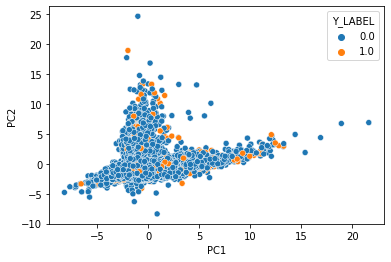

In [1640]:
sns.scatterplot(data=df,x='PC1',y='PC2',hue='Y_LABEL')

In [1641]:
import pickle

#저장하기
with open(f"./data/{file_version}_refined_train_X", 'wb') as pickle_filename:
	pickle.dump(train_X, pickle_filename)

with open(f"./data/{file_version}_refined_train_y", 'wb') as pickle_filename:
	pickle.dump(train_y, pickle_filename)
    
with open(f"./data/{file_version}_refined_val_X", 'wb') as pickle_filename:
	pickle.dump(val_X, pickle_filename)

with open(f"./data/{file_version}_refined_val_y", 'wb') as pickle_filename:
	pickle.dump(val_y, pickle_filename)
    
with open(f"./data/{file_version}_refined_test", 'wb') as pickle_filename:
	pickle.dump(test, pickle_filename)